In [60]:
# Reference: https://www.kaggle.com/code/uselessnoob/tensorflow-us-inflation-prediction?utm_source=chatgpt.com

# Dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

FORECAST_HORIZON = 6

In [61]:
# Load data (FRED-MD)
df = pd.read_csv('current.csv')

# Remove the first row (transformation codes)
transformation_codes = df.iloc[0]  # Transformation codes can be applied if needed
df = df.iloc[1:]

# Set the first column as the index and datetime
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)

data = df.dropna()

In [62]:
# Check NaN data
print(f"NaN: {data.isnull().sum().sum()}")
data.head()

NaN: 0


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-02-01,8444.994,7290.1,49.123,718889.123,164213.0,61.9192,70.4258,68.6473,80.2867,57.8121,...,67.191,52.129,11.89,13.67,11.30,68.8,64066.0,189752.08,744.1547,17.0505
1992-03-01,8457.388,7294.4,49.213,721782.597,163721.0,62.4403,71.0155,69.2529,81.0021,58.9931,...,67.363,52.284,11.92,13.76,11.32,76.0,62992.0,190887.95,749.5423,16.2227
1992-04-01,8487.783,7313.2,49.254,726592.639,164709.0,62.9199,71.5453,69.7742,81.7607,60.0895,...,67.390,52.481,11.96,13.77,11.36,77.2,64280.0,190911.80,756.0018,16.1885
1992-05-01,8531.932,7352.4,49.509,720270.973,165612.0,63.1268,71.9413,70.1855,82.2969,61.9726,...,67.482,52.543,11.97,13.77,11.39,79.2,62212.0,190975.14,765.6078,14.7280
1992-06-01,8566.719,7384.2,49.643,727863.941,166077.0,63.1624,71.7638,69.9644,81.8938,61.1178,...,67.792,52.619,12.01,13.88,11.41,80.4,63021.0,192729.46,774.6433,14.7531


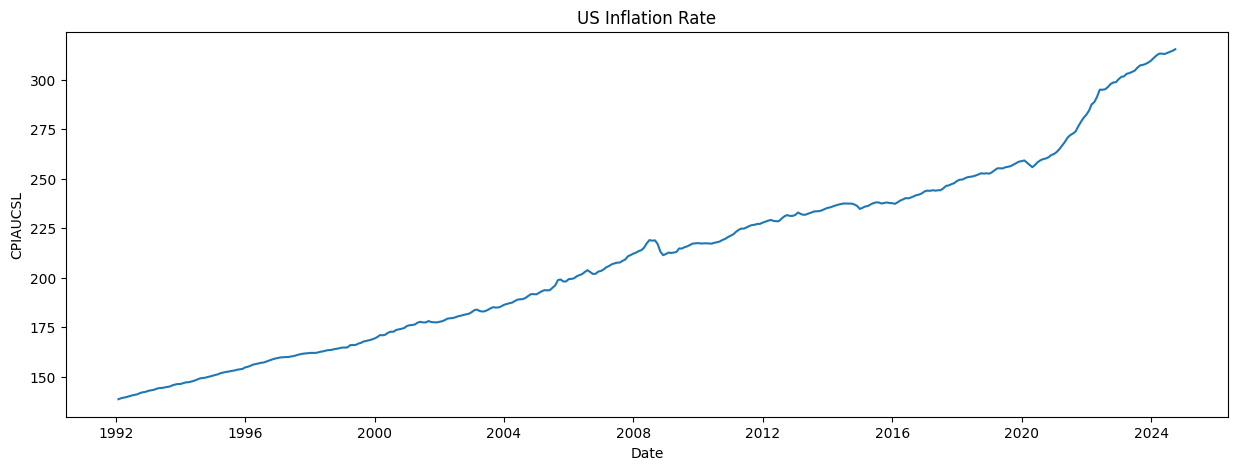

In [63]:
# Plot inflation
plt.figure(figsize=(15, 5))
plt.plot(data['CPIAUCSL'])
plt.title('US Inflation Rate')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.show()

In [64]:
# Create train data and target
target = data['CPIAUCSL']
train = data.drop(columns=['CPIAUCSL'])

In [65]:
# Convert data into sequences
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 4  # Have one quarter of context
X, y = create_sequences(train, target, time_steps)

# Split into train and test
split = len(X) - FORECAST_HORIZON # Last quarter for test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

/tmp/ipykernel_12867/3028046241.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps])


In [74]:
# Normalize the data
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])
    X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])

# Scale the target
scaler_target = MinMaxScaler()
y_train = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_target.transform(y_test.reshape(-1, 1))

In [76]:
# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0282
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012     
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9921e-04 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6663e-04 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4816e-04 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3496e-04 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8955e-04
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7207e-04 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5909e-04 
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3475e-04 
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4202e-04 
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2248e-04 
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3476e-04 
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━

In [103]:
# Predictions
train_predict = scaler_target.inverse_transform(model.predict(X_train).flatten().reshape(-1, 1))
test_predict = scaler_target.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [104]:
train_predict = pd.Series(train_predict.flatten(), index=data.index[:-FORECAST_HORIZON - time_steps])
test_predict = pd.Series(test_predict.flatten(), index=data.index[-FORECAST_HORIZON:])
y_original = pd.Series(y_train.flatten(), index=data.index[:-FORECAST_HORIZON - time_steps])
y_test_original = pd.Series(y_test.flatten(), index=data.index[-FORECAST_HORIZON:])


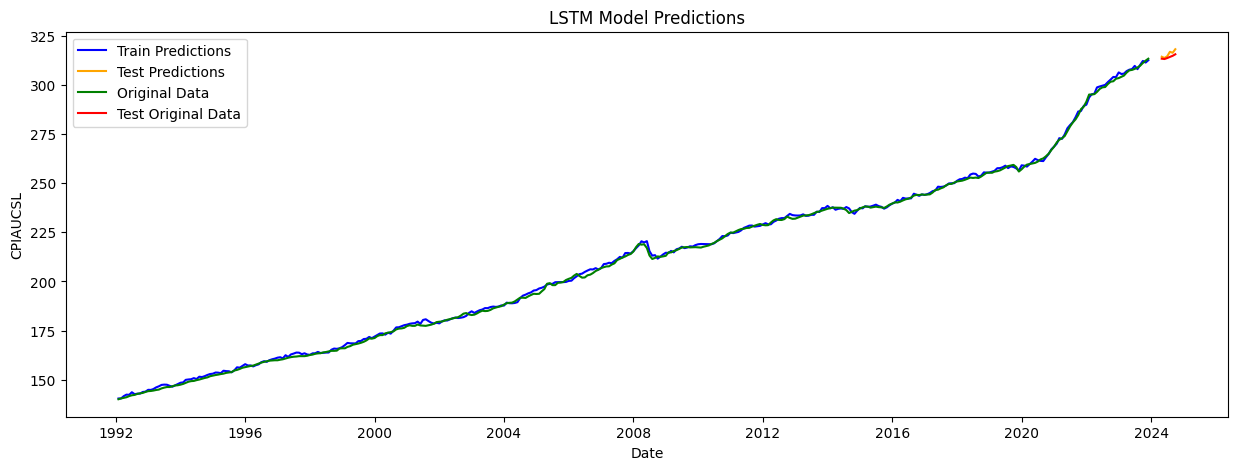

In [105]:
# Visualize
plt.figure(figsize=(15, 5))

plt.plot(train_predict, label='Train Predictions', color='blue')
plt.plot(test_predict, label='Test Predictions', color='orange')
plt.plot(y_original, label='Original Data', color='green')
plt.plot(y_test_original, label='Test Original Data', color='red')

plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.show()

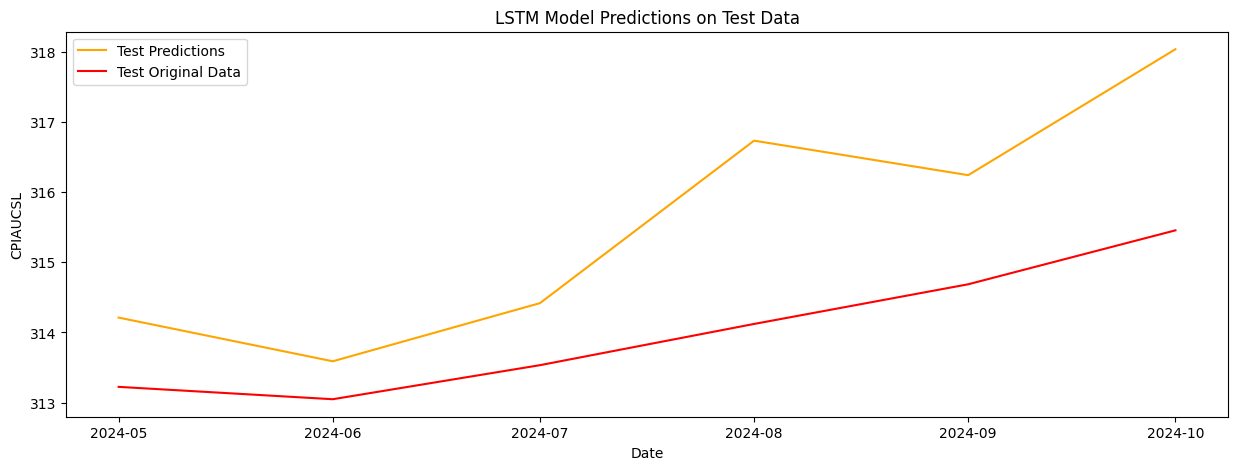

In [106]:
# Visualize testing
plt.figure(figsize=(15, 5))
plt.plot(test_predict, label='Test Predictions', color='orange')
plt.plot(y_test_original, label='Test Original Data', color='red')
plt.title('LSTM Model Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('CPIAUCSL')
plt.legend()
plt.show()

In [107]:
# RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))
print(f"RMSE: {rmse:.2f}")

RMSE: 1.73
